In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Tension Lab Analysis Code ヽ(•‿•)ノ

In [2]:
from os import listdir
Files = [x for x in listdir() if '.csv' in x and 'Steel' in x] #replace 'Raw' with something for a given type of sample, for example 'Al'
print(Files)

['A36 Steel Sample 1.csv', 'A36 Steel Sample 2.csv', 'A36 Steel Sample 3.csv']


In [3]:
thickness1 = 6.2 # Input thickness in mm
width1 = 12.4 # Input Width in mm
Area1 = thickness1*width1 #in mm^2

thickness2 = 6.2
width2 = 12.11
Area2 = thickness2*width2

thickness3 = 6.22
width3 = 12.4
Area3 = thickness3*width3

Areas = {'A36 Steel Sample 1.csv':Area1, 'A36 Steel Sample 2.csv':Area2,'A36 Steel Sample 3.csv':Area3}

In [4]:
import pandas as pd #pandas is the data analysis library
Data = {x:{} for x in Files} #This is a list comprehension that creates an empty dictionary for all the file data.
                             #It allows all the data to be stored in one place.
for File in Files:
    Data[File] = pd.read_csv(File) #this stores the data for each file in Data[File], where 'File' is the name of the file

In [5]:
import numpy as np
for File in Files:

    
    #Here's some example new dictionary calculations
    Data[File]['Strain (mm/mm)'] = Data[File]['Axial Strain (mm/mm)'] #this adds another strain column to the data
    Data[File]['Stress (MPa)'] = Data[File]['Load (N)']/Areas[File] #this adds stress to the data
    
    #You'll need to do calculations here
    Data[File]['Instantaneous Area (mm^2)'] = Areas[File]*((1- Data[File]['Transverse Strain (mm/mm)'])**2) #Calculate the instantaneous area using the original dimensions and the transverse strain
    Data[File]['True Stress (MPa)'] = Data[File]['Load (N)']/Data[File]['Instantaneous Area (mm^2)'] #Add in the true stress here
    Data[File]['True Strain (mm/mm)'] = np.log(1 + Data[File]['Strain (mm/mm)'])
    





## Plot All The Data

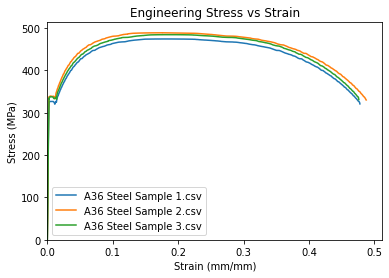

In [6]:
import matplotlib.pyplot as plt #matlab-esque plotting library
fig = plt.figure()
ax = fig.gca()
for File in Files:
    ax.plot(Data[File]['Strain (mm/mm)'],Data[File]['Stress (MPa)'],label=File) #the label corresponds to what the legend will output
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
plt.title("Engineering Stress vs Strain")
plt.ylabel('Stress (MPa)')
plt.xlabel('Strain (mm/mm)')
plt.legend() #this turns the legend on, you can manually change entries using legend(['Sample 1', 'Sample 2',...])
plt.show()

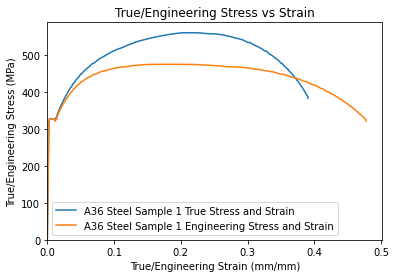

In [7]:
import matplotlib.pyplot as plt #matlab-esque plotting library
fig = plt.figure()
ax = fig.gca()
ax.plot(Data[Files[0]]['True Strain (mm/mm)'],Data[Files[0]]['True Stress (MPa)'],label='A36 Steel Sample 1 True Stress and Strain') #the label corresponds to what the legend will output
ax.plot(Data[Files[0]]['Strain (mm/mm)'],Data[Files[0]]['Stress (MPa)'],label='A36 Steel Sample 1 Engineering Stress and Strain')
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
plt.title("True/Engineering Stress vs Strain")
plt.ylabel('True/Engineering Stress (MPa)')
plt.xlabel('True/Engineering Strain (mm/mm)')
plt.legend() #this turns the legend on, you can manually change entries using legend(['Sample 1', 'Sample 2',...])
plt.show()

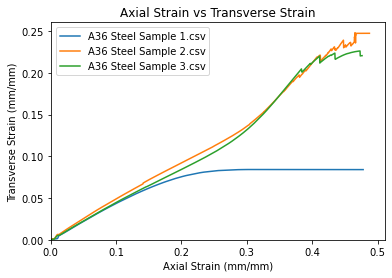

In [8]:
import matplotlib.pyplot as plt #matlab-esque plotting library
fig = plt.figure()
ax = fig.gca()
for File in Files:
    ax.plot(Data[File]['Axial Strain (mm/mm)'],Data[File]['Transverse Strain (mm/mm)'],label=File) #the label corresponds to what the legend will output
ax.set_xlim(left = 0)
ax.set_ylim(bottom = 0)
plt.title("Axial Strain vs Transverse Strain")
plt.ylabel('Transverse Strain (mm/mm)')
plt.xlabel('Axial Strain (mm/mm)')
plt.legend() #this turns the legend on, you can manually change entries using legend(['Sample 1', 'Sample 2',...])
plt.show()

## Young's Modulus Calculation 
#### We want to find the Young's modulus, i.e. the slope of stress vs strain in elastic region.
#### There are a few different ways to do this calculation, but the trick is defining the "elastic region".
#### You can define that region manually, or write a function that finds it for you.
#### This calculation is very nuanced and can change for different tests on different materials.

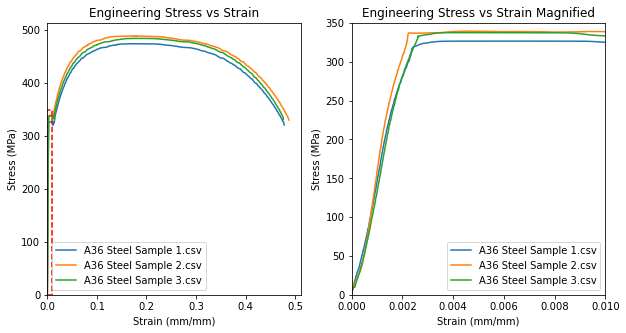

In [9]:
#Here we will make a subplot to show a zoomed section
eZoom = 0.01; sZoom = 350
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for File in Files:
    ax1.plot(Data[File]['Strain (mm/mm)'],Data[File]['Stress (MPa)'],label=File)
    ax2.plot(Data[File]['Strain (mm/mm)'],Data[File]['Stress (MPa)'],label=File)

#Plot the zoomed box
ax1.plot([0,0,eZoom,eZoom,0],[0,sZoom,sZoom,0,0],'r--')

#Add Labels
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)
ax2.set_xlim(left = 0, right=eZoom)
ax2.set_ylim(bottom = 0, top=sZoom)
ax1.set_title("Engineering Stress vs Strain")
ax2.set_title("Engineering Stress vs Strain Magnified")
ax1.set_ylabel('Stress (MPa)')
ax2.set_ylabel('Stress (MPa)')
ax1.set_xlabel('Strain (mm/mm)')
ax2.set_xlabel('Strain (mm/mm)')
ax1.legend()
ax2.legend()
plt.show()

### Modulus Fit
#### Here, we will only use the manual method of defining two indices for which to fit the data

In [10]:
from scipy.stats import linregress #This is a linear regression function built into the Scipy library. 
#You can call help(linregress) if you'd like to learn more. Or check out https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

def modulusFit(Strain,Stress,a,b):
    '''This is a linear fit to data between the data indices for a and b. Note, this will
    return an error if a or b are outside the length of Strain and Stress.'''
    
    #Fit the modulus
    E,C,R,P,Err = linregress(Strain[a:b],Stress[a:b]) #The data outputs the slope (E), intercept (C), regression (R) value, P-value and standard error
    #Note: Python lets you save multivariable outputs with a comma, i.e. a,b=[1,2] will give a=1 and b=2
    
    #Make a line for the fit data
    Y = [0.0, max(Stress)] #this is a list of length 2 for plotting the fit data later
    X = [(y-C)/E for y in Y] #these are points that you can plot to visualize the data being fit, inverted from y=E*x+C, x=(y-C)/E
    return E,C,R,X,Y

### Check how the fit works

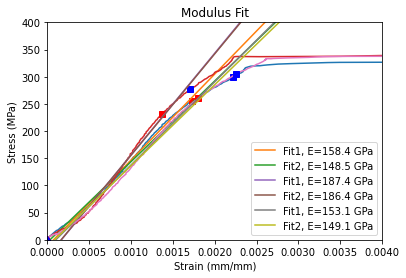

[158.40913783205696, 148.4578028524746, 187.3578605675808, 186.4452961210056, 153.1381883918535, 149.05726670621414]
[0.9978164852912325, 0.99558562002222, 0.989058833120704, 0.9934035994899767, 0.9967412614610828, 0.9970865016527415]


In [11]:
fig = plt.figure(1)
ax = fig.gca()

#We'll test out two fit points and see the difference
a1 = 0; b1 = 150
a2 = 0; b2 = 175

youngsModuli = []
ER2Values = []
for File in Files:
    #Save dummy variables to make the code cleaner below
    strain = Data[File]['Strain (mm/mm)'].values
    stress = Data[File]['Stress (MPa)'].values
    
    #Use the two fits
    E1,C1,R1,X1,Y1 = modulusFit(strain,stress,a1,b1)
    E2,C2,R2,X2,Y2 = modulusFit(strain,stress,a2,b2)
    
    #Plot the data
    ax.plot(strain,stress)
    ax.plot(strain[a1],stress[a1],'rd') #This is the first point we're fitting from 
    ax.plot(strain[b1],stress[b1],'rs') #this is the last point we're fitting to
#     ax.plot(strain[a1:b1],stress[a1:b1],'r.') #this will show all the data we're fitting
    ax.plot(strain[a2],stress[a2],'bd')
    ax.plot(strain[b2],stress[b2],'bs')
#     ax.plot(strain[a2:b2],stress[a2:b2],'b.') #this will show all the data we're fitting
    
    #Plot the fits|
    ax.plot(X1,Y1,label='Fit1, E='+str(round(E1*1e-3,1))+' GPa')
    ax.plot(X2,Y2,label='Fit2, E='+str(round(E2*1e-3,1))+' GPa')
    
    youngsModuli.append(E1*1e-3)
    youngsModuli.append(E2*1e-3)
    ER2Values.append(R1)
    ER2Values.append(R2)

ax.set_xlim(left = 0, right=0.004)
ax.set_ylim(bottom = 0, top=400)
plt.title("Modulus Fit")
plt.ylabel('Stress (MPa)')
plt.xlabel('Strain (mm/mm)')
plt.legend()
plt.show()
print(youngsModuli)
print(ER2Values)

#### You can see that slightly different 'linear regions' for measuring the slope can produce noticeably different results

#### Once you have found good fitting points, you will need to save these results and average them for all the data

#### Once you get all the values, you can find an average of the data

In [12]:
from numpy import mean,std 
#You can call the mean and std (standard deviation) for your Young's Moduli values
averageyoungsModulus = mean(youngsModuli)
stdyoungsModulus = std(youngsModuli)
print(averageyoungsModulus)
print(stdyoungsModulus)


163.81092541186428
16.649566234131893


## Poisson's Ratio Calculation
#### We need to measure the slope of the axial vs transverse strain to find the Poisson's ratio
#### We know that this is only valid in the linear elastic region, and we can use the same strain range from the modulus fit

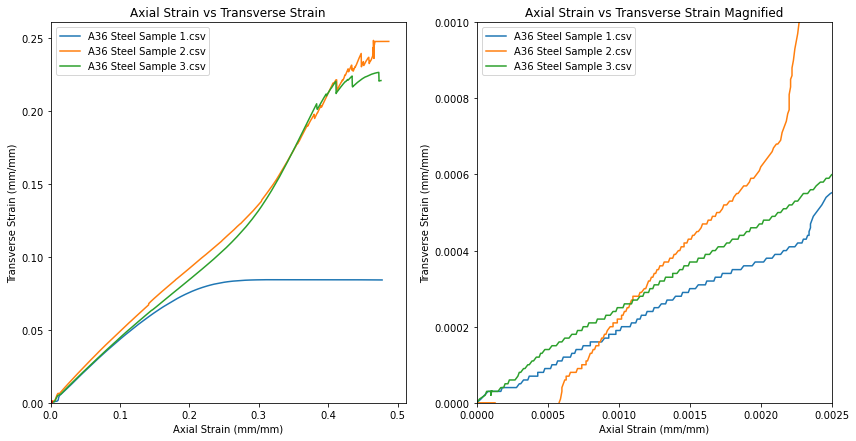

In [13]:
#Here we will make a subplot to show a zoomed section
#eZoom = 0.01; aZoom = 0.002
eZoom = 0.0025; aZoom = 0.001
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
for File in Files:
    ax1.plot(Data[File]['Axial Strain (mm/mm)'],Data[File]['Transverse Strain (mm/mm)'],label=File)
    ax2.plot(Data[File]['Axial Strain (mm/mm)'],Data[File]['Transverse Strain (mm/mm)'],label=File)

#Plot the zoomed box
ax1.plot([0,0,eZoom,eZoom,0],[0,aZoom,aZoom,0,0],'r--')

#Add Labels
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0)
ax2.set_xlim(left = 0, right=eZoom)
ax2.set_ylim(bottom = 0, top=aZoom)
ax1.set_title("Axial Strain vs Transverse Strain")
ax2.set_title("Axial Strain vs Transverse Strain Magnified")
ax1.set_xlabel('Axial Strain (mm/mm)')
ax2.set_xlabel('Axial Strain (mm/mm)')
ax1.set_ylabel('Transverse Strain (mm/mm)')
ax2.set_ylabel('Transverse Strain (mm/mm)')
ax1.legend()
ax2.legend()
plt.show()

#### We can define the same sort of slope fit function for Poisson's ratio 
#### We could also reuse the modulus fit funciton above, but we'll redefine it here with different variables just for clarity

In [14]:
from scipy.stats import linregress #This is a linear regression function built into the Scipy library. You can call help(linregress) if you'd like to learn more.

def PoissonFit(axialStrain,transverseStrain,a,b):
    '''This is a linear fit to data between the data indices for a and b. Note, this will
    return an error if a or b are outside the length of Strain.'''
    
    #Fit the modulus
    nu,C,R,P,Err = linregress(axialStrain[a:b],transverseStrain[a:b]) #The data outputs the slope (nu), intercept (C), regression (R) value, P-value and standard error
    #Note: Python lets you save multivariable outputs with a comma, i.e. a,b=[1,2] will give a=1 and b=2
    
    #Make a line for the fit data
    Y = [0.0, transverseStrain[round(1.5*b)]]
    X = [(y-C)/nu for y in Y] #these are points that you can plot to visualize the data being fit, inverted from y=nu*x+C, x=(y-C)/nu
    return nu,R,X,Y

#### Now let's see how the fit works

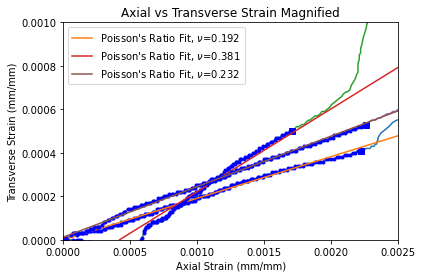

[0.19170425894991883, 0.38110913855036815, 0.2323172225903439]
[0.9978381545278892, 0.9686863124551462, 0.9987510336646621]


In [15]:
fig = plt.figure(5)
ax = fig.gca()
a = 0; b = 175#Note: you will have to play with these values for a given test type
PoissonsRatios = []
nuR2Values = []
for File in Files:
    #Create dummy variables to make plotting easier
    aStrain = Data[File]['Axial Strain (mm/mm)'].values
    tStrain = Data[File]['Transverse Strain (mm/mm)'].values
    
    #Do the fit
    nu,R,X,Y = PoissonFit(aStrain,tStrain,a,b)
    
    #Plot things
    ax.plot(aStrain,tStrain)
    ax.plot(aStrain[a],tStrain[a],'rd') #this is the first point we're fitting from
    ax.plot(aStrain[b],tStrain[b],'bs') #this is the last point we're fitting from
    ax.plot(aStrain[a:b],tStrain[a:b],'b.') #These are all the points we're fitting
    
    
    #Plot the fits
    ax.plot(X,Y,label=r"Poisson's Ratio Fit, $\nu$="+str(round(nu,3)))
    PoissonsRatios.append(nu)
    nuR2Values.append(R)
#Format the plot
ax.set_xlim(left = 0, right=0.0025)
ax.set_ylim(bottom = 0, top=0.001)
plt.title("Axial vs Transverse Strain Magnified")
plt.xlabel('Axial Strain (mm/mm)')
plt.ylabel('Transverse Strain (mm/mm)')
plt.legend()
plt.show()

print(PoissonsRatios)
print(nuR2Values)

#### You can see that the Poisson's ratio fit isn't  perfect and, like the modulus fit, will change depending on exactly where we fit the data.
#### You will need to play with these values for each data set to make sure you are fitting the correct region

In [16]:
from numpy import mean,std 
averagePoissonsRatio = mean(PoissonsRatios)
stdPoissonsRatios = std(PoissonsRatios)
print(averagePoissonsRatio)
print(stdPoissonsRatios)

0.2683768733635436
0.08141980068152553


## Yield strength calculation

#### We will define a function for finding the yield stress based on the 0.2% offset method
#### Note that this is only applicable for ductile materials

In [17]:
def yieldStress(Strain,Stress,E,C,eOffset=0.002):
    '''This function will find the yield stress based on a 0.2% offset strain method.
    You must input the stress, strain, Youngs modulus E, fit line intercept point b, and
    can change the strain offset value.'''
    
    yP = next(i for i,x in enumerate(Strain) if Stress[i] < E*(x-eOffset) + C)
    #This code finds the first point where the Stress exceeds the strain offset line defined by y=E*(x-eOffset)+b
    #This is the simplest way to determine a slope intercept, but it only works if the stress and the offset line intersect
    
    return yP #this returns the index i of the yield stress, if you want it to return the stress, use: return Stress[yP]

#### Brief aside - here's a quick look at the function we just used

In [18]:
aList = [1,3,5,2,1,6,8,7] #this is a list of integers
aListSquared = [x**2 for x in aList] #this is a list comprehension that squares every entry in aList, it will go through the list elements sequentially
aListIndex = [i for i,x in enumerate(aList)] #this spits out all the indices of the elements in a list, here just 0,1,2,3...
aListPart = [x for x in aList if x>4] #this finds all the list elements that are greater than 4
aListNext = next(x for x in aList if x>4) #this finds the next list element that is greater than 4
aListNextIndex = next(i for i,x in enumerate(aList) if x>4) #this finds the index of the next list value greater than 4
print(aList)
print(aListSquared)
print(aListIndex)
print(aListPart)
print(aListNext)
print(aListNextIndex)
print(aList[aListNextIndex])

[1, 3, 5, 2, 1, 6, 8, 7]
[1, 9, 25, 4, 1, 36, 64, 49]
[0, 1, 2, 3, 4, 5, 6, 7]
[5, 6, 8, 7]
5
2
5


#### Let's see how that yield function works by plotting the results!

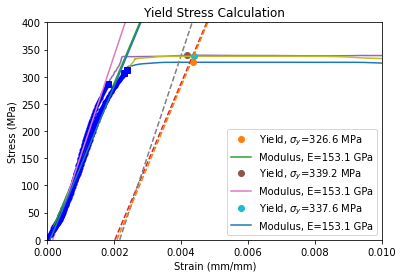

[326.63709677419354, 339.19155057137533, 337.5666424644746]
[0.9946018974782133, 0.993668237505036, 0.9966542278559525]


In [19]:
import matplotlib.pyplot as plt 

fig = plt.figure()
ax = fig.gca()
a = 0; b = 180 #Note: you will have to play with these values for a given test type
eOff = 0.002
yieldStrengths = []
yR2Values = []

for File in Files:
    strain = Data[File]['Strain (mm/mm)'].values
    stress = Data[File]['Stress (MPa)'].values
    
    #Find modulus and yield
    E,C,R,X,Y = modulusFit(strain,stress,a,b)
    iYield = yieldStress(strain,stress,E,C,eOffset=eOff)
    xOffset = [x+eOff for x in X]
    
    yieldStrengths.append(Data[File]['Stress (MPa)'][iYield])
    yR2Values.append(R)
    
    #Plot the data
    ax.plot(strain,stress)
    ax.plot(strain[a],stress[a],'bd') #This is the first point we're fitting from
    ax.plot(strain[b],stress[b],'bs') #this is the last point we're fitting from
    ax.plot(strain[a:b],stress[a:b],'b.') #These are all the points we're fitting
    ax.plot(strain[iYield],stress[iYield],'o', label=r'Yield, $\sigma_y$='+str(round(stress[iYield],1))+' MPa')
    
    #Plot the fits
    ax.plot(X,Y,label='Modulus, E='+str(round(E1*1e-3,1))+' GPa')
    ax.plot(xOffset,Y,'--')

ax.set_xlim(left = 0, right=0.01)
ax.set_ylim(bottom = 0, top=400)
plt.title("Yield Stress Calculation")
plt.ylabel('Stress (MPa)')
plt.xlabel('Strain (mm/mm)')
plt.legend()
plt.show()

print(yieldStrengths)
print(yR2Values)

In [20]:
from numpy import mean,std 
print(mean(yieldStrengths))
print(std(yieldStrengths))

334.46509660334783
5.574840361415302


## Calculate Some Ultimate Values

#### Ultimate Stress and Strain Calculation

In [21]:
ultimateStresses = []
ultimateStrains = []
for File in Files:
    ultimateStress = Data[File]['Stress (MPa)'].max()
    ultimateStrain = next(x for i,x in enumerate(Data[File]['Strain (mm/mm)'].values) if Data[File]['Stress (MPa)'][i] == ultimateStress) #calculate the ultimate strain here, i.e. the strain at the ultimate stress
    print("Ultimate Stress =", round(ultimateStress,1), "MPa for",File) 
    print("Ultimate Strain =", ultimateStrain, "for",File) 
    ultimateStresses.append(ultimateStress)
    ultimateStrains.append(ultimateStrain)

    
print('\n')
print('Average Ultimate Tensile Stress =',mean(ultimateStresses),'MPa')
print('Ultimate Tensile Stress Std',std(ultimateStresses),'MPa')
print('Average Ultimate Tensile Strain =',mean(ultimateStrains))
print('Ultimate Tensile Strain Std',std(ultimateStrains))

Ultimate Stress = 474.2 MPa for A36 Steel Sample 1.csv
Ultimate Strain = 0.18087 for A36 Steel Sample 1.csv
Ultimate Stress = 488.9 MPa for A36 Steel Sample 2.csv
Ultimate Strain = 0.17563 for A36 Steel Sample 2.csv
Ultimate Stress = 484.3 MPa for A36 Steel Sample 3.csv
Ultimate Strain = 0.18705 for A36 Steel Sample 3.csv


Average Ultimate Tensile Stress = 482.5113970546002 MPa
Ultimate Tensile Stress Std 6.137800424475015 MPa
Average Ultimate Tensile Strain = 0.18118333333333334
Ultimate Tensile Strain Std 0.004667457075919981


#### Fracture Stress and Strain Calculation

In [22]:
fractureStresses = []
fractureStrains = []
for File in Files:
    fractureStress = Data[File]['Stress (MPa)'][len(Data[File]['Stress (MPa)'])-1]
    fractureStrain = Data[File]['Strain (mm/mm)'][len(Data[File]['Stress (MPa)'])-1]
    fractureStresses.append(fractureStress)
    fractureStrains.append(fractureStrain)
    
print('Average Fracture Stress =',mean(fractureStresses),'MPa')
print('Fracture Stress Std =',std(fractureStresses),'MPa')

print('Average Fracture Strain =',mean(fractureStrains))
print('Fracture Strain Std =',std(fractureStrains))

 

Average Fracture Stress = 327.3407386358942 MPa
Fracture Stress Std = 4.569034063758658 MPa
Average Fracture Strain = 0.4803866666666667
Fracture Strain Std = 0.004955672395234505


### Percent Elongation Calculation

In [23]:
#Input the sample parameters
Lo = 25.4 #initial sample length, change for each specimen

for File in Files:
    deltaL = Data[File]['Extension (mm)'].max()
    L = Lo+deltaL
    percentElongation = deltaL/Lo

print(percentElongation)
    

0.8858267716535434


## Calculate the Disspiated Energy

#### Tensile toughness

In [24]:
#There are many integration functions built into python libraries, here we will use numpy trapozoidal rule
from numpy import trapz #this is the trapezoidal rule integration function
toughnesses = []
#We want to integrate over axial stress and strain to find the area under the curve
for File in Files:
    #Choose your data
    yData = Data[File]['Stress (MPa)']
    xData = Data[File]['Axial Strain (mm/mm)']
    
    #Calculate the area
    tensileToughness = trapz(yData,x=xData) #if we don't include xData, it will take the spacing to be 1
    
    #Print the result
    print('Tensile toughness =',round(tensileToughness,2),'MPa') #We're rounding to the nearest 0.01
    toughnesses.append(tensileToughness)
    
print('Average Tensile Toughness =',mean(toughnesses),'MPa')
print('Tensile Toughness Std =',std(toughnesses),'MPa')
    

Tensile toughness = 208.58 MPa
Tensile toughness = 219.81 MPa
Tensile toughness = 212.68 MPa
Average Tensile Toughness = 213.68968433729128 MPa
Tensile Toughness Std = 4.64108360875762 MPa


#### Modulus of resilience

In [25]:
#There are many integration functions built into python libraries, here we will use numpy trapozoidal rule
from numpy import trapz #this is the trapezoidal rule integration function

def yieldStress(Strain,Stress,E,C,eOffset=0.002):
    '''This function will find the yield stress based on a 0.2% offset strain method.
    You must input the stress, strain, Youngs modulus E, fit line intercept point b, and
    can change the strain offset value.'''
    
    yP = next(i for i,x in enumerate(Strain) if Stress[i] < E*(x-eOffset) + C)
    #This code finds the first point where the Stress exceeds the strain offset line defined by y=E*(x-eOffset)+b
    #This is the simplest way to determine a slope intercept, but it only works if the stress and the offset line intersect
    
    return yP #this returns the index i of the yield stress, if you want it to return the stress, use: return Stress[yP]


mResiliences = []
for File in Files:
    strain = Data[File]['Axial Strain (mm/mm)']
    stress = Data[File]['Stress (MPa)']
    eOff = 0.002
    #Find modulus and yield
    E,C,R,X,Y = modulusFit(strain,stress,a,b)
    iYield = yieldStress(strain,stress,E,C,eOffset=eOff)
   
    yData = Data[File]['Stress (MPa)'][0:iYield]
    xData = Data[File]['Axial Strain (mm/mm)'][0:iYield]
    
    #Calculate the area
    mResilience = round(trapz(yData,x=xData),2) #if we don't include xData, it will take the spacing to be 1
    print('Resilience of sample:',mResilience,'MPa')
    mResiliences.append(mResilience)
    
print('Average resilience =',mean(mResiliences),'MPa')
print('Resilience std =',std(mResiliences),'MPa')

#We want to integrate over axial stress and strain to find the area under the curve

    #### Here you will need to use the yield strength point that was calculated above (or recalculate it here)
    #### to find the modulus of resilience of the material
    #### You can copy the process in the 'tensile toughness' section above, or use a different method
#     print('Modulus of Resilience = ', round(modulusOfResilience,2)),'MPa') #We're rounding to the nearest 0.01
    

Resilience of sample: 0.97 MPa
Resilience of sample: 0.97 MPa
Resilience of sample: 1.0 MPa
Average resilience = 0.98 MPa
Resilience std = 0.014142135623730965 MPa
